# Fluvial-Pluvial Delineation

### Validation and Verification

**Delineation Quality Checks**:

1. **Hydraulic Connectivity**
   - Verify fluvial flooding is connected to river/stream
   - Check pluvial areas are isolated from channel
   - Validate flow path analysis

2. **Threshold Sensitivity**
   - Test multiple distance thresholds
   - Document threshold selection rationale
   - Check for reasonable transitions between classes

3. **Physical Plausibility**
   - Low areas far from channels should be pluvial
   - Areas adjacent to channels should be fluvial
   - Check for unrealistic classifications

4. **Comparison with Field Observations**
   - Known flooding sources (if available)
   - Historical flood extents
   - Local knowledge validation

**Output Verification**:
```python
# Check classification statistics
fluvial_area = (classified_raster == 1).sum() * pixel_area
pluvial_area = (classified_raster == 2).sum() * pixel_area
print(f"Fluvial: {fluvial_area / 1e6:.2f} km²")
print(f"Pluvial: {pluvial_area / 1e6:.2f} km²")
print(f"Ratio: {fluvial_area / pluvial_area:.2f}")
```

### Professional Review Requirements
- [ ] Methodology peer reviewed
- [ ] Threshold selection documented and justified
- [ ] Results compared with historical flooding patterns
- [ ] Uncertainty quantified and communicated
- [ ] Limitations clearly stated in deliverables
- [ ] Licensed professional certification (if regulatory use)

### Fluvial vs Pluvial Flooding

**Definitions**:
- **Fluvial**: River/stream overflow flooding (channel-driven)
- **Pluvial**: Surface water flooding from direct rainfall (not channel-driven)

**Why Delineation Matters**:
- Different mitigation strategies
- Different regulatory frameworks
- Different risk assessment methods
- Compound flooding may occur (both types simultaneously)

**This Notebook Demonstrates**:
- Spatial delineation using HEC-RAS 2D results
- Attribution based on flow paths and connectivity
- Visualization of flood source areas

### Reference
- [FEMA Flood Insurance Study Guidelines](https://www.fema.gov/flood-maps/guidance-partners/guidelines-standards)
- [Urban Drainage and Flood Control District Guidelines](https://udfcd.org/criteria-manual/)
- HEC-RAS 2D Modeling User's Manual (compound flooding chapter)

### Professional Context
Fluvial/pluvial delineation is critical for:
- Flood risk communication to stakeholders
- Insurance rating and premiums
- Infrastructure design (different protection levels)
- Regulatory compliance (separate standards may apply)

**Important**: This is a **demonstration workflow**. Professional delineation requires:
- Review by licensed professional engineer
- Validation against field observations
- Consideration of site-specific hydraulics
- Peer review of methodology

In [1]:
# =============================================================================
# DEVELOPMENT MODE TOGGLE
# =============================================================================
USE_LOCAL_SOURCE = False  # <-- TOGGLE THIS

if USE_LOCAL_SOURCE:
    import sys
    from pathlib import Path
    local_path = str(Path.cwd().parent)
    if local_path not in sys.path:
        sys.path.insert(0, local_path)
    print(f"📁 LOCAL SOURCE MODE: Loading from {local_path}/ras_commander")
else:
    print("📦 PIP PACKAGE MODE: Loading installed ras-commander")

# Import ras-commander
from ras_commander import HdfBase, HdfFluvialPluvial, HdfMesh, HdfResultsMesh, HdfResultsPlot, HdfUtils, RasCmdr, RasExamples, RasPlan, init_ras_project, ras

# Verify which version loaded
import ras_commander
print(f"✓ Loaded: {ras_commander.__file__}")

📦 PIP PACKAGE MODE: Loading installed ras-commander
✓ Loaded: c:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\ras_commander\__init__.py


## Parameters

Configure these values to customize the notebook for your project.

In [2]:
# =============================================================================
# PARAMETERS - Edit these to customize the notebook
# =============================================================================
from pathlib import Path

# Project Configuration
PROJECT_NAME = "BaldEagleCrkMulti2D"           # Example project to extract
RAS_VERSION = "6.6"               # HEC-RAS version (6.3, 6.5, 6.6, etc.)

# HDF Analysis Settings
PLAN = "06"                       # Plan number (for HDF file path)
TIME_INDEX = -1                   # Time step index (-1 = last)
PROFILE = "Max"                   # Profile name for steady analysis


# Delineate Fluvial and Pluvial Areas using RAS-Commander

We will leverage the HEC RAS Summary Outputs to delineate the Fluvial and Pluvial Areas

Maximum Water Surface Elevation (WSEL) for each cell is recorded, along with the timestamps of when the maximum WSEL occurs.

By locating adjacent cells with dissimilar timestamps, we can delineate the Fluvial and Pluvial Areas.




A note about datframe types: 

Information from the HEC-RAS plan files are generally dataframes.  The text file interface is for the 32-bit side of HEC-RAS and all spatial data is most easily accessed in the HDF files.  This includes plan_df, geom_df, hdf_paths_df

Geometry elements (Mesh Faces and Nodes) are provided as Geodataframes (cell_polygons_gdf, boundary_gdf)


## Package Installation and Environment Setup
Uncomment and run package installation commands if needed

In [3]:
# Install ras-commander from pip (uncomment to install if needed)
#!pip install ras-commander
# This installs ras-commander and all dependencies

In [4]:
# Import all required modules
#from ras_commander import HdfBase, HdfMesh, HdfResultsMesh, HdfResultsPlot, HdfUtils, RasCmdr, RasExamples, RasPlan, init_ras_project, ras  # Import all ras-commander modules

# Import the required libraries for this notebook
import h5py
import numpy as np
import requests
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import pyproj
from shapely.geometry import Point, LineString, Polygon
import xarray as xr
from pathlib import Path

In [5]:
# Download the BaldEagleCrkMulti2D project from HEC and run plan 06

# Define the path to the BaldEagleCrkMulti2D project
import logging

# Extract project using suffix parameter (returns correct path)
bald_eagle_path = RasExamples.extract_project(PROJECT_NAME, suffix="14")

# Initialize the RAS project using the default global ras object
init_ras_project(bald_eagle_path, RAS_VERSION)
logging.info(f"Bald Eagle project initialized with folder: {ras.project_folder}")

# Use the plan number from parameters
plan_number = PLAN

# Update the run flags in the plan file
RasPlan.update_run_flags(
    plan_number,
    geometry_preprocessor=True,  # Run HTab
    unsteady_flow_simulation=True,  # Run UNet
    post_processor=True,  # Run PostProcess
    floodplain_mapping=False,  # Run RASMapper
)

# Execute Plan 06 using RasCmdr with skip_existing=True
# This will skip execution if HDF results already exist with "Complete Process"
print(f"Executing Plan {plan_number} for the Bald Eagle Creek project...")
success_bald_eagle = RasCmdr.compute_plan(plan_number, skip_existing=True)
if success_bald_eagle:
    print(f"Plan {plan_number} executed successfully (or skipped - results exist).")
else:
    print(f"Plan {plan_number} execution failed for Bald Eagle.")

2026-01-12 23:58:26 - ras_commander.RasExamples - INFO - Found zip file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\Example_Projects_6_6.zip
2026-01-12 23:58:26 - ras_commander.RasExamples - INFO - Loading project data from CSV...
2026-01-12 23:58:26 - ras_commander.RasExamples - INFO - Loaded 68 projects from CSV.
2026-01-12 23:58:26 - ras_commander.RasExamples - INFO - ----- RasExamples Extracting Project -----
2026-01-12 23:58:26 - ras_commander.RasExamples - INFO - Extracting project 'BaldEagleCrkMulti2D' as 'BaldEagleCrkMulti2D_14'
2026-01-12 23:58:29 - ras_commander.RasExamples - INFO - Successfully extracted project 'BaldEagleCrkMulti2D' to C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_14
2026-01-12 23:58:31 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCr

Executing Plan 06 for the Bald Eagle Creek project...


2026-01-13 00:44:04 - ras_commander.RasCmdr - INFO - HEC-RAS execution completed for plan: 06
2026-01-13 00:44:04 - ras_commander.RasCmdr - INFO - Total run time for plan 06: 2732.82 seconds
2026-01-13 00:44:04 - ras_commander.hdf.HdfResultsPlan - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_14\BaldEagleDamBrk.p06.hdf
2026-01-13 00:44:04 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_14\BaldEagleDamBrk.p06.hdf
2026-01-13 00:44:04 - ras_commander.hdf.HdfResultsPlan - INFO - Reading computation messages from HDF: BaldEagleDamBrk.p06.hdf
2026-01-13 00:44:04 - ras_commander.hdf.HdfResultsPlan - INFO - Successfully extracted 1694 characters from HDF
2026-01-13 00:44:04 - ras_commander.hdf.HdfResultsPlan - INFO - Using existing Path object HDF f

Plan 06 executed successfully (or skipped - results exist).


In [6]:
# Display results summary from results_df
ras.results_df[['plan_number', 'plan_title', 'completed', 'has_errors', 'has_warnings', 'runtime_complete_process_hours']]

,plan_number,plan_title,completed,has_errors,has_warnings,runtime_complete_process_hours
0,13,PMF with Multi 2D Areas,False,False,False,NaN
1,15,1d-2D Dambreak Refined Grid,False,False,False,NaN
2,17,2D to 1D No Dam,False,False,False,NaN
3,18,2D to 2D Run,False,False,False,NaN
4,19,SA to 2D Dam Break Run,False,False,False,NaN
5,03,Single 2D Area - Internal Dam Structure,False,False,False,NaN
6,04,SA to 2D Area Conn - 2D Levee Structure,False,False,False,NaN
7,02,SA to Detailed 2D Breach,False,False,False,NaN
8,01,SA to Detailed 2D Breach FEQ,False,False,False,NaN
9,05,Single 2D area with Bridges FEQ,False,False,False,NaN


###  OPTIONAL: Use your own project instead

your_project_path = Path(r"D:\yourprojectpath")

init_ras_project(your_project_path, "6.6")
plan_number = "01"  # Plan number to use for this notebook 



### If you use this code cell, don't run the previous cell or change to markdown
### NOTE: Ensure the HDF Results file was generated by HEC-RAS Version 6.x or above

# Explore Project Dataframes using 'ras' Object

In [7]:
# Load Plan and Geometry Dataframes and find Plan and Geometry HDF Paths

# Display plan_df for bald_eagle project
print("Plan DataFrame for bald_eagle project:")
ras.plan_df

Plan DataFrame for bald_eagle project:


,plan_number,unsteady_number,geometry_number,Plan Title,Program Version,Short Identifier,Simulation Date,Computation Interval,Mapping Interval,Run HTab,...,DSS File,Friction Slope Method,UNET D2 SolverType,UNET D2 Name,HDF_Results_Path,Geom File,Geom Path,Flow File,Flow Path,full_path
0,13,07,06,PMF with Multi 2D Areas,5.10,PMF Multi 2D,"01JAN1999,1200,04JAN1999,1200",30SEC,30MIN,1,...,dss,1,Pardiso (Direct),193,None,06,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,07,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...
1,15,12,08,1d-2D Dambreak Refined Grid,5.10,1D-2D Refined Grid,"01JAN1999,1200,04JAN1999,1200",20SEC,5MIN,1,...,dss,1,NaN,BaldEagleCr,None,08,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,12,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...
2,17,09,10,2D to 1D No Dam,5.00,2D to 1D No Dam,"01JAN1999,1200,06JAN1999,1200",1MIN,5MIN,1,...,dss,1,NaN,Upstream2D,None,10,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,09,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...
3,18,10,11,2D to 2D Run,5.00,2D to 2D Run,"01JAN1999,1200,04JAN1999,1200",20SEC,5MIN,1,...,dss,1,NaN,BaldEagleCr,None,11,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,10,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...
4,19,11,12,SA to 2D Dam Break Run,5.00,SA to 2D Dam Break,"01JAN1999,1200,04JAN1999,1200",20SEC,10MIN,1,...,dss,1,NaN,BaldEagleCr,None,12,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,11,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...
5,03,13,09,Single 2D Area - Internal Dam Structure,5.04,Single 2D,"01JAN1999,1200,04JAN1999,1200",30SEC,10MIN,1,...,dss,1,NaN,BaldEagleCr,None,09,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,13,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...
6,04,01,13,SA to 2D Area Conn - 2D Levee Structure,5.00,2D Levee Struc,"01JAN1999,1200,04JAN1999,1200",20SEC,5MIN,1,...,dss,1,NaN,BaldEagleCr,None,13,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,01,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...
7,02,01,01,SA to Detailed 2D Breach,5.10,SA-2D Det Brch,"01JAN1999,1200,04JAN1999,1200",10SEC,5MIN,1,...,dss,1,Pardiso (Direct),BaldEagleCr,None,01,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,01,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...
8,01,01,01,SA to Detailed 2D Breach FEQ,5.03,SA-2D Det FEQ,"01JAN1999,1200,04JAN1999,1200",5SEC,5MIN,1,...,dss,1,NaN,BaldEagleCr,None,01,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,01,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...
9,05,02,03,Single 2D area with Bridges FEQ,5.10,Single 2D Bridges FEQ,"01JAN1999,1200,04JAN1999,1200",5SEC,10MIN,-1,...,dss,1,PARDISO (Direct),BaldEagleCr,None,03,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,02,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...


In [8]:
print("\nGeometry DataFrame for the project:")
ras.geom_df


Geometry DataFrame for the project:


,geom_file,geom_number,full_path,hdf_path
0,g06,06,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...
1,g08,08,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...
2,g10,10,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...
3,g11,11,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...
4,g12,12,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...
5,g09,09,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...
6,g13,13,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...
7,g01,01,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...
8,g03,03,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...
9,g02,02,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...


In [9]:
print("\nUnsteady DataFrame for the project:")
ras.unsteady_df


Unsteady DataFrame for the project:


,unsteady_number,full_path,Flow Title,Program Version,Use Restart,Precipitation Mode,Wind Mode,Met BC=Precipitation|Mode,Met BC=Evapotranspiration|Mode,Met BC=Precipitation|Expanded View,Met BC=Precipitation|Constant Units,Met BC=Precipitation|Gridded Source
0,07,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,PMF with Multi 2D Areas,5.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,08,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,PMF for Upstream 2D,4.20,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,09,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,Upstream 2D,5.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,1972 Flood Event - 2D to 2D Run,5.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,1972 Flood Event - SA to 2D Run,5.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,12,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,PMF for 1D - 2D,5.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,13,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,Single 2D Area,5.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,01,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,1972 Flood Event - 2D Leve Structure,5.10,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,02,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,Single 2D Area with Bridges,5.10,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,03,C:\Users\billk_clb\anaconda3\envs\rascmdr_pipt...,Gridded Precipitation,6.00,0,Enable,No Wind Forces,Gridded,None,-1,mm/hr,DSS


In [10]:
print("\nBoundary Conditions DataFrame for the project:")
ras.boundaries_df 


Boundary Conditions DataFrame for the project:


,unsteady_number,boundary_condition_number,river_reach_name,river_station,storage_area_name,pump_station_name,bc_type,hydrograph_type,Interval,DSS File,...,Flow Title,Program Version,Use Restart,Precipitation Mode,Wind Mode,Met BC=Precipitation|Mode,Met BC=Evapotranspiration|Mode,Met BC=Precipitation|Expanded View,Met BC=Precipitation|Constant Units,Met BC=Precipitation|Gridded Source
0,07,1,Bald Eagle Cr.,Lock Haven,137520,,Flow Hydrograph,Flow Hydrograph,1HOUR,Bald_Eagle_Creek.dss,...,PMF with Multi 2D Areas,5.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,07,2,Bald Eagle Cr.,Lock Haven,81454,,Gate Opening,None,NaN,NaN,...,PMF with Multi 2D Areas,5.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,07,3,Bald Eagle Cr.,Lock Haven,28519,,Lateral Inflow Hydrograph,Lateral Inflow Hydrograph,1HOUR,Bald_Eagle_Creek.dss,...,PMF with Multi 2D Areas,5.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,07,4,Bald Eagle Cr.,Lock Haven,1,,Lateral Inflow Hydrograph,Lateral Inflow Hydrograph,1HOUR,NaN,...,PMF with Multi 2D Areas,5.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,07,5,Bald Eagle Cr.,Lock Haven,136948,82303,Uniform Lateral Inflow Hydrograph,Uniform Lateral Inflow Hydrograph,1HOUR,Bald_Eagle_Creek.dss,...,PMF with Multi 2D Areas,5.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,07,6,Bald Eagle Cr.,Lock Haven,80720,67130,Uniform Lateral Inflow Hydrograph,Uniform Lateral Inflow Hydrograph,1HOUR,Bald_Eagle_Creek.dss,...,PMF with Multi 2D Areas,5.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,07,7,Bald Eagle Cr.,Lock Haven,76865,,Lateral Inflow Hydrograph,Lateral Inflow Hydrograph,1HOUR,Bald_Eagle_Creek.dss,...,PMF with Multi 2D Areas,5.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,07,8,Bald Eagle Cr.,Lock Haven,67130,,Lateral Inflow Hydrograph,Lateral Inflow Hydrograph,1HOUR,Bald_Eagle_Creek.dss,...,PMF with Multi 2D Areas,5.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,07,9,Bald Eagle Cr.,Lock Haven,66041,1,Uniform Lateral Inflow Hydrograph,Uniform Lateral Inflow Hydrograph,1HOUR,Bald_Eagle_Creek.dss,...,PMF with Multi 2D Areas,5.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,07,10,Bald Eagle Cr.,Lock Haven,-1867,,Normal Depth,None,NaN,NaN,...,PMF with Multi 2D Areas,5.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Find Paths for Results and Geometry HDF's

In [11]:
# Use the plan_number defined earlier
print(f"Using plan number: {plan_number}")

# Get the plan HDF path for the plan_number defined above
plan_hdf_path = ras.plan_df.loc[ras.plan_df['plan_number'] == plan_number, 'HDF_Results_Path'].values[0]

Using plan number: 06


In [12]:
plan_hdf_path

'C:\\Users\\billk_clb\\anaconda3\\envs\\rascmdr_piptest\\Lib\\site-packages\\examples\\example_projects\\BaldEagleCrkMulti2D_14\\BaldEagleDamBrk.p06.hdf'

In [13]:
# Get the geometry HDF path
geom_hdf_path = ras.plan_df.loc[ras.plan_df['plan_number'] == plan_number, 'Geom Path'].values[0] + '.hdf'

In [14]:
geom_hdf_path


'C:\\Users\\billk_clb\\anaconda3\\envs\\rascmdr_piptest\\Lib\\site-packages\\examples\\example_projects\\BaldEagleCrkMulti2D_14\\BaldEagleDamBrk.g09.hdf'

In [15]:
print(f"\nPlan HDF path for Plan {plan_number}: {plan_hdf_path}")
print(f"Geometry HDF path for Plan {plan_number}: {geom_hdf_path}")


Plan HDF path for Plan 06: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_14\BaldEagleDamBrk.p06.hdf
Geometry HDF path for Plan 06: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_14\BaldEagleDamBrk.g09.hdf


# Fluvial Pluvial Delineation using RAS-Commander 

Using the Maximum WSE Results layer, which contains the maximum water surface and time stamp of the maximum water surface, mesh cell faces are categorized.  If the difference in time (delta_t) in hours is greater than the (user defined, default 12) duration specified, that mesh cell face is added to the fluvial-pluvial boundary dataset. 

This is meant to provide a draft fluvial-pluvial boundary for floodplain analysis, to the extent it can be derived directly from the HEC-RAS results files. 

The function attempts to combine adjacent line segments to simplify the resulting geometry, but GIS cleanup and manual interpolation will be required to create a closed polygon boundary that could be used for further processing steps.  However, this approach does provide an efficient method for providing a draft boundary that is based on HEC-RAS's direct computations and mesh cell faces. 

In [16]:
# Using mesh_max_ws, get the cell coordinates and plot the max water surface as a map
import matplotlib.pyplot as plt
from ras_commander import HdfMesh
from ras_commander import HdfResultsMesh
from shapely.geometry import Point

# Get mesh max water surface
max_ws_df = HdfResultsMesh.get_mesh_max_ws(plan_hdf_path)

print("max_ws_df")
print(max_ws_df)

# If you get an error here, you may have a pre-6.0 HDF.  Re-run in 6.x to generate a new results file

2026-01-13 00:44:05 - ras_commander.hdf.HdfResultsMesh - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_14\BaldEagleDamBrk.p06.hdf
2026-01-13 00:44:05 - ras_commander.hdf.HdfResultsMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_14\BaldEagleDamBrk.p06.hdf
2026-01-13 00:44:05 - ras_commander.hdf.HdfResultsMesh - INFO - Processing summary output for variable: Maximum Water Surface
2026-01-13 00:44:05 - ras_commander.hdf.HdfMesh - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_14\BaldEagleDamBrk.p06.hdf
2026-01-13 00:44:05 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\

max_ws_df
         mesh_name  cell_id  maximum_water_surface maximum_water_surface_time  \
0      BaldEagleCr        0             704.054443        2018-09-10 18:00:00   
1      BaldEagleCr        1             692.377991        2018-09-10 18:04:00   
2      BaldEagleCr        2             671.183472        2018-09-10 18:13:20   
3      BaldEagleCr        3             660.605469        2018-09-10 18:54:40   
4      BaldEagleCr        4             660.586243        2018-09-10 18:55:20   
...            ...      ...                    ...                        ...   
19592  BaldEagleCr    19592               0.000000        2018-09-09 00:00:00   
19593  BaldEagleCr    19593               0.000000        2018-09-09 00:00:00   
19594  BaldEagleCr    19594               0.000000        2018-09-09 00:00:00   
19595  BaldEagleCr    19595               0.000000        2018-09-09 00:00:00   
19596  BaldEagleCr    19596               0.000000        2018-09-09 00:00:00   

                 

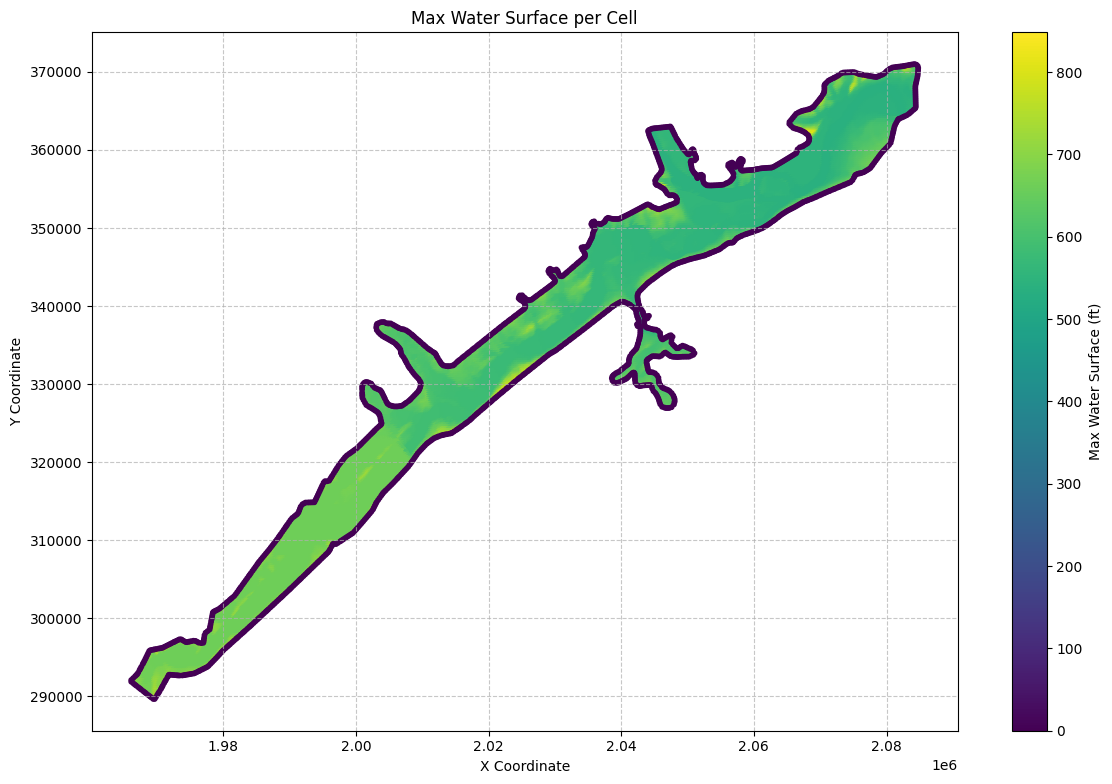

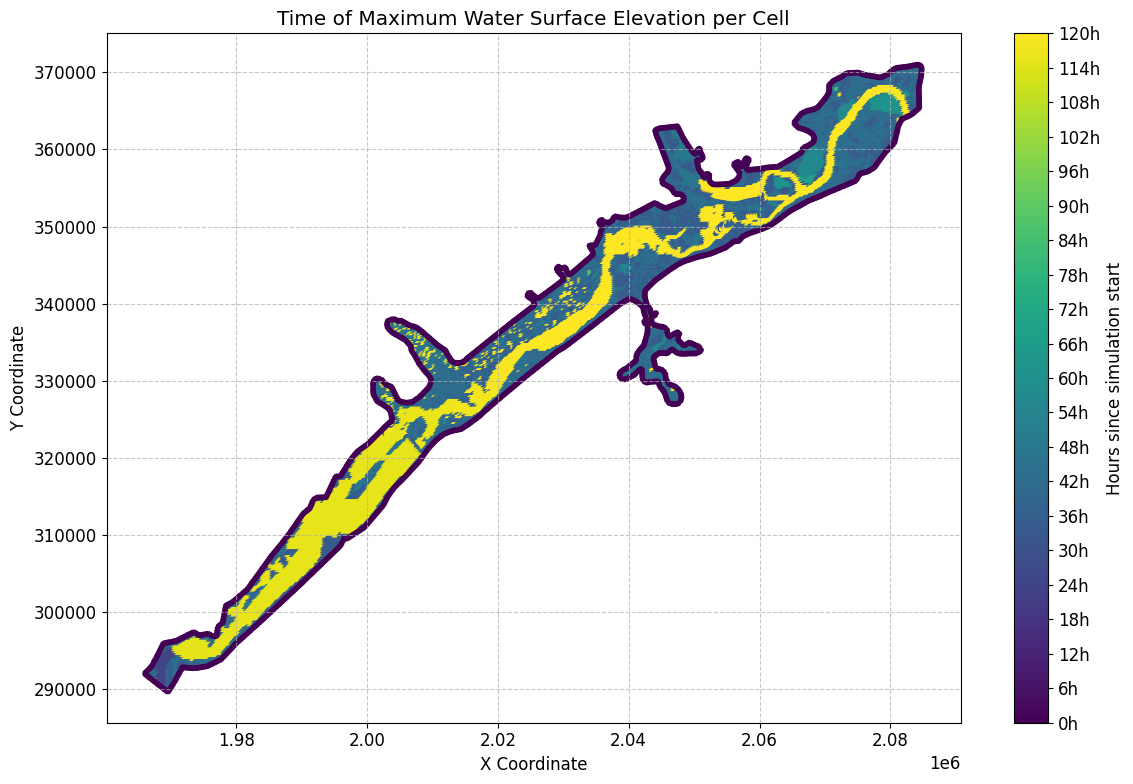


Simulation Start Time: 2018-09-09 00:00:00
Time Range: 120.0 hours

Timing Statistics (hours since start):
count    19597.000000
mean        63.225561
std         40.179612
min          0.000000
25%         34.000000
50%         42.700000
75%        115.677778
max        120.000000
Name: max_wsel_time, dtype: float64

First few rows of the merged dataframe:


,mesh_name,cell_id,maximum_water_surface,maximum_water_surface_time,geometry,x,y,max_wsel_time
0,BaldEagleCr,0,704.054443,2018-09-10 18:00:00,POINT (2083000 370750),2.083000e+06,370750.000000,2018-09-10 18:00:00
1,BaldEagleCr,1,692.377991,2018-09-10 18:04:00,POINT (2083250 370750),2.083250e+06,370750.000000,2018-09-10 18:04:00
2,BaldEagleCr,2,671.183472,2018-09-10 18:13:20,POINT (2083500 370750),2.083500e+06,370750.000000,2018-09-10 18:13:20
3,BaldEagleCr,3,660.605469,2018-09-10 18:54:40,POINT (2083750 370750),2.083750e+06,370750.000000,2018-09-10 18:54:40
4,BaldEagleCr,4,660.586243,2018-09-10 18:55:20,POINT (2084000 370750),2.084000e+06,370750.000000,2018-09-10 18:55:20
...,...,...,...,...,...,...,...,...
19592,BaldEagleCr,19592,0.000000,2018-09-09 00:00:00,POINT (1978423.032 300718.897),1.978423e+06,300718.897016,2018-09-09 00:00:00
19593,BaldEagleCr,19593,0.000000,2018-09-09 00:00:00,POINT (1973389.375 297311.928),1.973389e+06,297311.928472,2018-09-09 00:00:00
19594,BaldEagleCr,19594,0.000000,2018-09-09 00:00:00,POINT (1968834.79 295808.861),1.968835e+06,295808.860743,2018-09-09 00:00:00
19595,BaldEagleCr,19595,0.000000,2018-09-09 00:00:00,POINT (1966130.942 291879.395),1.966131e+06,291879.394946,2018-09-09 00:00:00


In [17]:
# Call the function to plot
HdfResultsPlot.plot_results_max_wsel(max_ws_df)

# Plot the time of maximum water surface elevation
HdfResultsPlot.plot_results_max_wsel_time(max_ws_df)

# Print the first few rows of the merged dataframe for verification
print("\nFirst few rows of the merged dataframe:")
max_ws_df


In [18]:
# Use HdfUtils for extracting projection
print("\nExtracting Projection from HDF")
projection = HdfBase.get_projection(hdf_path=geom_hdf_path)
if projection:
    print(f"Projection: {projection}")
else:
    print("No projection information found.")

2026-01-13 00:44:06 - ras_commander.hdf.HdfBase - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_14\BaldEagleDamBrk.g09.hdf
2026-01-13 00:44:06 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_14\BaldEagleDamBrk.g09.hdf
2026-01-13 00:44:06 - ras_commander.hdf.HdfBase - INFO - Found projection in HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_14\BaldEagleDamBrk.g09.hdf
2026-01-13 00:44:06 - ras_commander.hdf.HdfBase - INFO - Converted WKT to EPSG:2271 from HDF file BaldEagleDamBrk.g09.hdf



Extracting Projection from HDF
Projection: EPSG:2271


In [19]:
# Example: Extract Cell Polygons
print("\nExample 6: Extracting Cell Polygons")
cell_polygons_gdf = HdfMesh.get_mesh_cell_polygons(geom_hdf_path)


# Call the function to plot cell polygons
#cell_polygons_gdf = HdfFluvialPluvial.plot_cell_polygons(cell_polygons_gdf, projection)


2026-01-13 00:44:06 - ras_commander.hdf.HdfMesh - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_14\BaldEagleDamBrk.g09.hdf
2026-01-13 00:44:06 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_14\BaldEagleDamBrk.g09.hdf
2026-01-13 00:44:06 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_14\BaldEagleDamBrk.g09.hdf
2026-01-13 00:44:06 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_14\BaldEagleDamBrk.g09.hdf
2026-01-13 00:44:06 - ras_commander.hdf.HdfMesh - INFO - Using existing Path 


Example 6: Extracting Cell Polygons


2026-01-13 00:44:07 - ras_commander.hdf.HdfBase - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_14\BaldEagleDamBrk.g09.hdf
2026-01-13 00:44:07 - ras_commander.hdf.HdfBase - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_14\BaldEagleDamBrk.g09.hdf
2026-01-13 00:44:07 - ras_commander.hdf.HdfBase - INFO - Found projection in HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_14\BaldEagleDamBrk.g09.hdf
2026-01-13 00:44:07 - ras_commander.hdf.HdfBase - INFO - Converted WKT to EPSG:2271 from HDF file BaldEagleDamBrk.g09.hdf
2026-01-13 00:44:08 - ras_commander.hdf.HdfBase - INFO - Using HDF file from h5py.File object: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\

In [20]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import LineString, Polygon, MultiLineString
from collections import defaultdict
from tqdm import tqdm
from rtree import index


# Example usage:
boundary_gdf = HdfFluvialPluvial.calculate_fluvial_pluvial_boundary(plan_hdf_path, delta_t=72)

2026-01-13 00:44:08 - ras_commander.hdf.HdfFluvialPluvial - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_14\BaldEagleDamBrk.p06.hdf
2026-01-13 00:44:08 - ras_commander.hdf.HdfFluvialPluvial - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_14\BaldEagleDamBrk.p06.hdf
2026-01-13 00:44:08 - ras_commander.hdf.HdfFluvialPluvial - INFO - Getting cell polygons from HDF file...
2026-01-13 00:44:08 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_14\BaldEagleDamBrk.p06.hdf
2026-01-13 00:44:08 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_project

In [21]:
# Calculate statistics about the boundary line lengths
boundary_lengths = boundary_gdf.geometry.length

print("Boundary line length statistics:")
print(f"Max length: {boundary_lengths.max():.2f}")
print(f"Min length: {boundary_lengths.min():.2f}")
print(f"Average length: {boundary_lengths.mean():.2f}")
print(f"Median length: {boundary_lengths.median():.2f}")

# Print general information about the boundary GeoDataFrame
print("\nBoundary GeoDataFrame info:")
print(boundary_gdf.info())

Boundary line length statistics:
Max length: 441.63
Min length: 1.57
Average length: 242.54
Median length: 250.00

Boundary GeoDataFrame info:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3201 entries, 0 to 3200
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  3201 non-null   geometry
dtypes: geometry(1)
memory usage: 25.1 KB
None


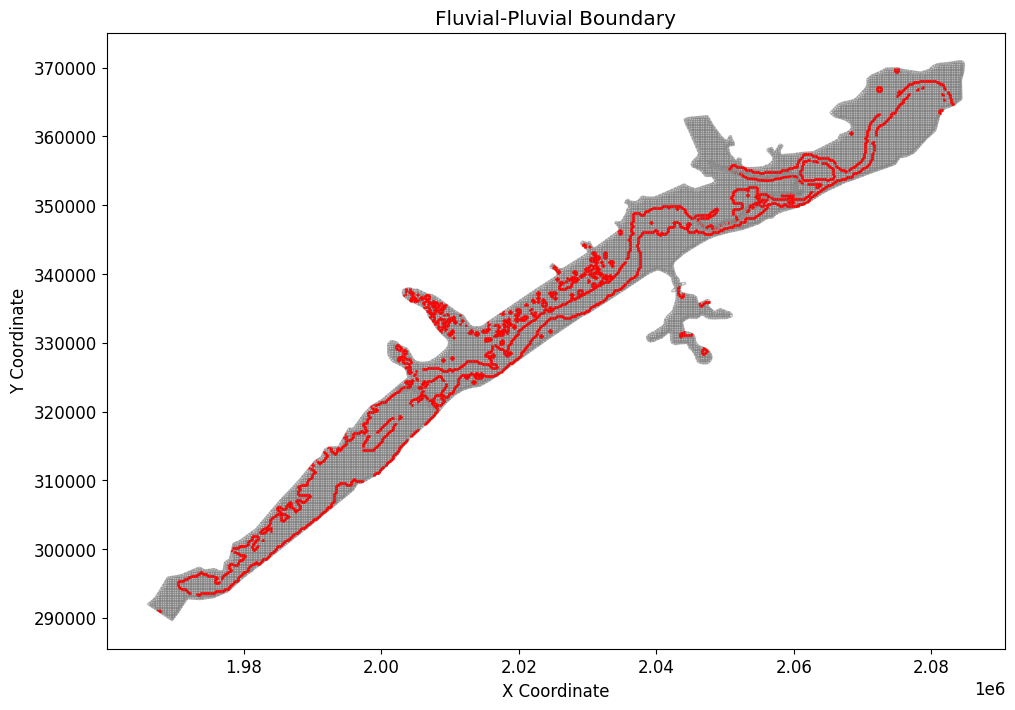

In [22]:
# Visualize the results
fig, ax = plt.subplots(figsize=(12, 8))
cell_polygons_gdf.plot(ax=ax, edgecolor='gray', facecolor='none', alpha=0.5)
boundary_gdf.plot(ax=ax, color='red', linewidth=2)
plt.title('Fluvial-Pluvial Boundary')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

C:\Users\billk_clb\AppData\Local\Temp\ipykernel_182040\1399630256.py:10: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  filtered_boundary_gdf.plot(ax=ax, color='red', linewidth=2, label='Valid Boundaries')


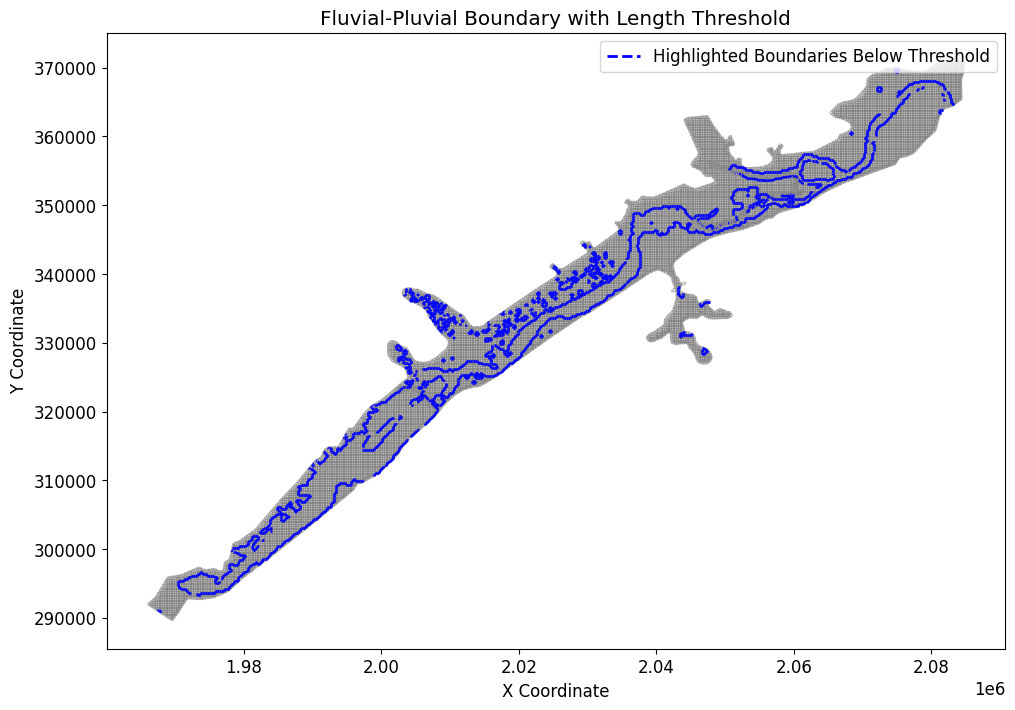

In [23]:
length_threshold = 3000 #in same units as X and Y coordinates

# Filter out boundary lines below the length threshold
filtered_boundary_gdf = boundary_gdf[boundary_lengths >= length_threshold]
highlighted_boundary_gdf = boundary_gdf[boundary_lengths < length_threshold]

# Visualize the results with highlighted boundaries below the threshold
fig, ax = plt.subplots(figsize=(12, 8))
cell_polygons_gdf.plot(ax=ax, edgecolor='gray', facecolor='none', alpha=0.5)
filtered_boundary_gdf.plot(ax=ax, color='red', linewidth=2, label='Valid Boundaries')
highlighted_boundary_gdf.plot(ax=ax, color='blue', linewidth=2, linestyle='--', label='Highlighted Boundaries Below Threshold')
plt.title('Fluvial-Pluvial Boundary with Length Threshold')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.show()


In [24]:
# Example usage using Optional min_line_length argument:
boundary_gdf = HdfFluvialPluvial.calculate_fluvial_pluvial_boundary(plan_hdf_path, delta_t=72, min_line_length=3000)

2026-01-13 00:44:19 - ras_commander.hdf.HdfFluvialPluvial - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_14\BaldEagleDamBrk.p06.hdf
2026-01-13 00:44:19 - ras_commander.hdf.HdfFluvialPluvial - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_14\BaldEagleDamBrk.p06.hdf
2026-01-13 00:44:19 - ras_commander.hdf.HdfFluvialPluvial - INFO - Getting cell polygons from HDF file...
2026-01-13 00:44:19 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_14\BaldEagleDamBrk.p06.hdf
2026-01-13 00:44:19 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_project

2026-01-13 00:44:24 - ras_commander.hdf.HdfFluvialPluvial - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_14\BaldEagleDamBrk.p06.hdf
2026-01-13 00:44:24 - ras_commander.hdf.HdfFluvialPluvial - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_14\BaldEagleDamBrk.p06.hdf
2026-01-13 00:44:24 - ras_commander.hdf.HdfFluvialPluvial - INFO - Loading mesh and results data...
2026-01-13 00:44:24 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_14\BaldEagleDamBrk.p06.hdf
2026-01-13 00:44:24 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Bald

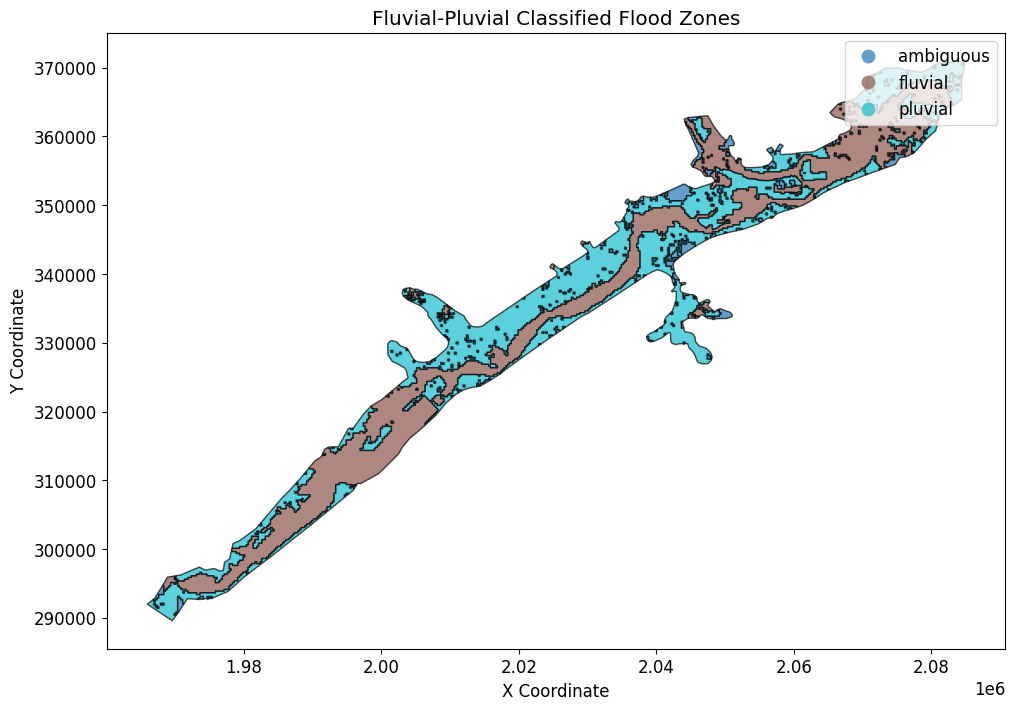

In [25]:
# To get the classified flood zones as polygons:
flood_polygons_gdf = HdfFluvialPluvial.generate_fluvial_pluvial_polygons(
    plan_hdf_path, 
    delta_t=10, 
    temporal_tolerance_hours=1.0,
    min_polygon_area_acres=1000
)

flood_polygons_gdf

# Plot the classified flood zones as polygons, colored by classification
fig, ax = plt.subplots(figsize=(12, 8))
flood_polygons_gdf.plot(
    ax=ax,
    column="classification",
    categorical=True,
    legend=True,
    edgecolor="black",
    alpha=0.7
)
plt.title("Fluvial-Pluvial Classified Flood Zones")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()


2026-01-13 00:44:32 - ras_commander.hdf.HdfFluvialPluvial - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_14\BaldEagleDamBrk.p06.hdf
2026-01-13 00:44:32 - ras_commander.hdf.HdfFluvialPluvial - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_14\BaldEagleDamBrk.p06.hdf
2026-01-13 00:44:32 - ras_commander.hdf.HdfFluvialPluvial - INFO - Loading mesh and results data...
2026-01-13 00:44:32 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_14\BaldEagleDamBrk.p06.hdf
2026-01-13 00:44:32 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Bald

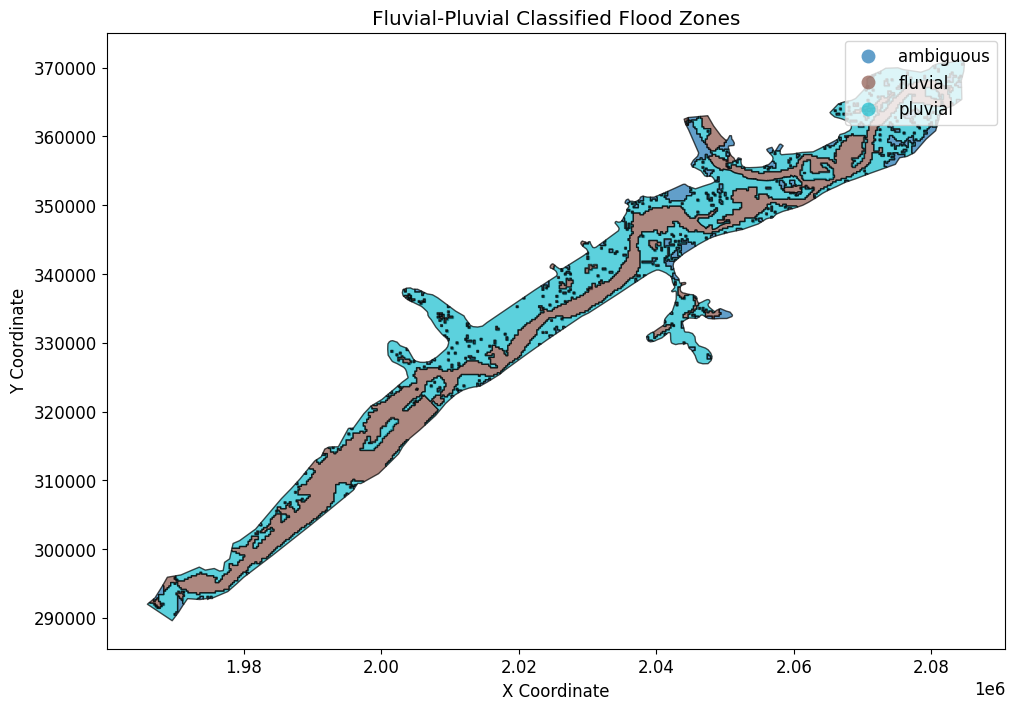

In [26]:
# To get the classified flood zones as polygons:
flood_polygons_gdf = HdfFluvialPluvial.generate_fluvial_pluvial_polygons(
    plan_hdf_path, 
    delta_t=12, 
    temporal_tolerance_hours=1.0,
    min_polygon_area_acres=200
)

flood_polygons_gdf

# Plot the classified flood zones as polygons, colored by classification
fig, ax = plt.subplots(figsize=(12, 8))
flood_polygons_gdf.plot(
    ax=ax,
    column="classification",
    categorical=True,
    legend=True,
    edgecolor="black",
    alpha=0.7
)
plt.title("Fluvial-Pluvial Classified Flood Zones")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()


2026-01-13 00:44:39 - ras_commander.hdf.HdfFluvialPluvial - INFO - Using HDF file from direct string path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_14\BaldEagleDamBrk.p06.hdf
2026-01-13 00:44:39 - ras_commander.hdf.HdfFluvialPluvial - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_14\BaldEagleDamBrk.p06.hdf
2026-01-13 00:44:39 - ras_commander.hdf.HdfFluvialPluvial - INFO - Loading mesh and results data...
2026-01-13 00:44:39 - ras_commander.hdf.HdfMesh - INFO - Using existing Path object HDF file: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_14\BaldEagleDamBrk.p06.hdf
2026-01-13 00:44:39 - ras_commander.hdf.HdfMesh - INFO - Final validated file path: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\Bald

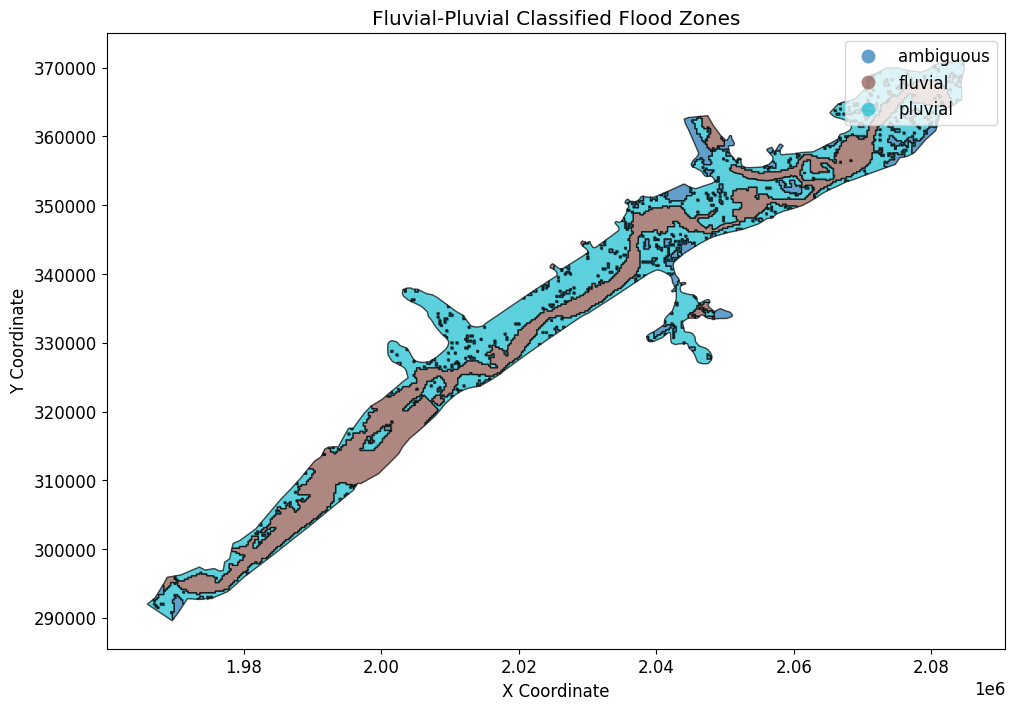

In [27]:
# To get the classified flood zones as polygons:
flood_polygons_gdf = HdfFluvialPluvial.generate_fluvial_pluvial_polygons(
    plan_hdf_path, 
    delta_t=14, 
    temporal_tolerance_hours=1.0,
    min_polygon_area_acres=1000
)

flood_polygons_gdf

# Plot the classified flood zones as polygons, colored by classification
fig, ax = plt.subplots(figsize=(12, 8))
flood_polygons_gdf.plot(
    ax=ax,
    column="classification",
    categorical=True,
    legend=True,
    edgecolor="black",
    alpha=0.7
)
plt.title("Fluvial-Pluvial Classified Flood Zones")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()


In [28]:
flood_polygons_gdf.to_file(driver='GeoJSON', filename='flood_polygons.geojson')

2026-01-13 00:44:46 - pyogrio._io - INFO - Created 3 records


In [29]:
# Create fluvial_pluvial_boundary subfolder in project directory
output_dir = ras.project_folder / "fluvial_pluvial_boundary"
output_dir.mkdir(exist_ok=True)
print(f"Output directory created/verified at: {output_dir}")

# Save to GeoJSON in output directory
boundary_gdf.to_file(output_dir / 'fluvial_pluvial_boundary.geojson', driver='GeoJSON')

2026-01-13 00:44:46 - pyogrio._io - INFO - Created 0 records


Output directory created/verified at: C:\Users\billk_clb\anaconda3\envs\rascmdr_piptest\Lib\site-packages\examples\example_projects\BaldEagleCrkMulti2D_14\fluvial_pluvial_boundary
